In [4]:
#!pip install roboflow

In [1]:
from roboflow import Roboflow
rf = Roboflow(api_key="IFOX6RwrxhvdgMaBeLBA")
project = rf.workspace("pcd-rxiqe").project("satellite-curb-segmentation")
version = project.version(6)
dataset = version.download("sam2")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Satellite-Curb-Segmentation-6 in sam2:: 100%|███████| 35/35 [00:00<00:00, 5667.98it/s]


In [3]:
import os
import re

DATASET_VERSION = "Satellite-Curb-Segmentation-5"
FOLDER = DATASET_VERSION + "/train"

for filename in os.listdir(FOLDER):
    # Replace all except last dot with underscore
    new_filename = filename.replace(".", "_", filename.count(".") - 1)
    if not re.search(r"_\d+\.\w+$", new_filename):
        # Add an int to the end of base name
        new_filename = new_filename.replace(".", "_1.")
    os.rename(os.path.join(FOLDER, filename), os.path.join(FOLDER, new_filename))

In [32]:
#!wget -O ./sam2/configs/train.yaml 'https://drive.usercontent.google.com/download?id=11cmbxPPsYqFyWq87tmLgBAQ6OZgEhPG3'

In [30]:
!python training/train.py -c 'configs/train.yaml' --use-cluster 0 --num-gpus 1

###################### Train App Config ####################
scratch:
  resolution: 1024
  train_batch_size: 1
  num_train_workers: 10
  num_frames: 1
  max_num_objects: 3
  base_lr: 5.0e-06
  vision_lr: 3.0e-06
  phases_per_epoch: 1
  num_epochs: 40
dataset:
  img_folder: Satellite-Curb-Segmentation-5/train
  gt_folder: Satellite-Curb-Segmentation-5/train
  multiplier: 2
vos:
  train_transforms:
  - _target_: training.dataset.transforms.ComposeAPI
    transforms:
    - _target_: training.dataset.transforms.RandomHorizontalFlip
      consistent_transform: true
    - _target_: training.dataset.transforms.RandomAffine
      degrees: 25
      shear: 20
      image_interpolation: bilinear
      consistent_transform: true
    - _target_: training.dataset.transforms.RandomResizeAPI
      sizes: ${scratch.resolution}
      square: true
      consistent_transform: true
    - _target_: training.dataset.transforms.ColorJitter
      consistent_transform: true
      brightness: 0.1
      contrast:

In [31]:
!pip install supervision -q

In [1]:
import torch
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
import supervision as sv
import os
import random
from PIL import Image
import numpy as np

# use bfloat16 for the entire notebook
# from Meta notebook
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

checkpoint = "sam2_logs/configs/train.yaml/checkpoints/checkpoint.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_b+.yaml"
sam2 = build_sam2(model_cfg, checkpoint, device="cuda")
mask_generator = SAM2AutomaticMaskGenerator(sam2)

checkpoint_base = "checkpoints/sam2.1_hiera_base_plus.pt"
model_cfg_base = "configs/sam2.1/sam2.1_hiera_b+.yaml"
sam2_base = build_sam2(model_cfg_base, checkpoint_base, device="cuda")
mask_generator_base = SAM2AutomaticMaskGenerator(sam2_base)

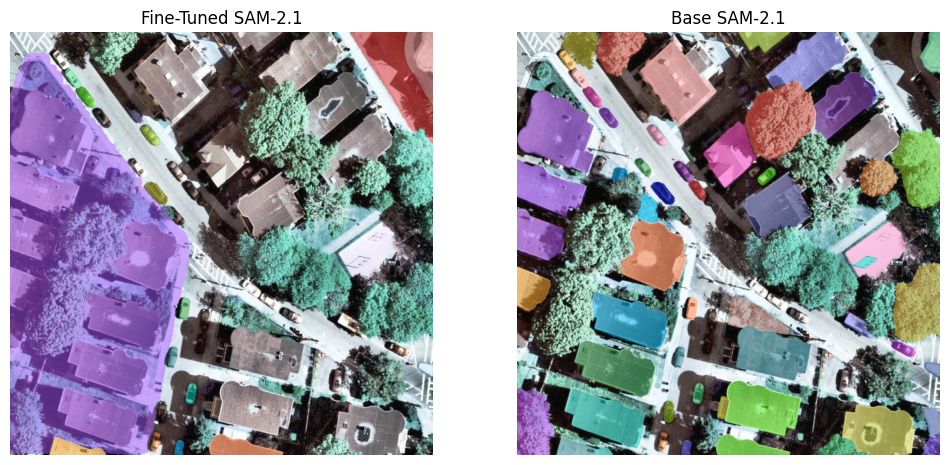

In [11]:
validation_set = os.listdir(DATASET_VERSION + "/test")

# choose random with .json extension
image = random.choice([img for img in validation_set if img.endswith(".jpg")])
image = os.path.join(DATASET_VERSION + "/test", image)
opened_image = np.array(Image.open(image).convert("RGB"))
result = mask_generator.generate(opened_image)

detections = sv.Detections.from_sam(sam_result=result)

mask_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)
annotated_image = opened_image.copy()
annotated_image = mask_annotator.annotate(annotated_image, detections=detections)

base_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)

base_result = mask_generator_base.generate(opened_image)
base_detections = sv.Detections.from_sam(sam_result=base_result)
base_annotated_image = opened_image.copy()
base_annotated_image = base_annotator.annotate(base_annotated_image, detections=base_detections)

sv.plot_images_grid(images=[annotated_image, base_annotated_image], titles=["Fine-Tuned SAM-2.1", "Base SAM-2.1"], grid_size=(1, 2))